In [1]:
import pandas as pd
import numpy as np
from numba.experimental.jitclass.base import imp_dtor
from sklearn.model_selection import train_test_split

# try 20250830_cleaned_kick.csv
# read the kick dataset
df = pd.read_csv('data/020925_cleaned_kick.csv')
# show all columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41436 entries, 0 to 41435
Columns: 125 entries, VehOdo to VNST_WV
dtypes: bool(116), float64(7), int64(2)
memory usage: 7.4 MB


In [2]:
# Separate features and target
X = df.drop('IsBadBuy', axis=1)
Y = df['IsBadBuy']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(categorical_cols)
print(numerical_cols)

[]
['VehOdo', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'VehUsedAge']


In [3]:
# Create a 30% train/test split from our samples.
# We set the random_state to the constant 10 to ensure it is the same from run-to-run.
# We set the stratisfy parameter to the labels, that way we get an even selection of 0 and 1 values in our testing set.
# Otherwise, we may end up with unbalanced 0/1 labels across the two splits.
# We use X.values to get arrays for the features, instead of a DataFrame with column names etc.
random_state = 10
test_set_size = 0.3 # 30%
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values,test_size=test_set_size, stratify=Y, random_state=random_state)
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 29005
Size of testing set: 12431


In [4]:
from sklearn.preprocessing import StandardScaler
random_seed = 10
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
model = MLPClassifier(max_iter=700, random_state=random_state)
model.fit(X_train, y_train)

MLPClassifier(max_iter=700, random_state=10)

In [6]:
# Print model performance for the first model training
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.9556628167557317
Test accuracy: 0.8178746681682889
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     10821
           1       0.23      0.18      0.20      1610

    accuracy                           0.82     12431
   macro avg       0.56      0.55      0.55     12431
weighted avg       0.80      0.82      0.81     12431



In [14]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
# hide warnings from optimizer not converging
import warnings
warnings.filterwarnings('ignore')
# hide warnings in subprocesses, required because we use multiple n_jobs
import os
os.environ["PYTHONWARNINGS"] = "ignore"
hl_test_set_cv1 = [
        (1,), (3,),(5,),(10,), (20,), (40,), (60,), (80,),  # Single layers
    ]
params = {'hidden_layer_sizes': hl_test_set_cv1}
cv_1 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), return_train_score=True, cv=10,
n_jobs=-1)
cv_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1,), (3,), (5,), (10,), (20,),
                                                (40,), (60,), (80,)]},
             return_train_score=True)

In [15]:
# GridsearchCV model result
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 1.68055599,  2.52779715,  3.8266808 ,  6.15776596,  8.30369616,
       12.80695684, 17.29380295, 18.78442261]), 'std_fit_time': array([0.1956339 , 0.24894754, 0.67187379, 0.89725488, 0.75546106,
       0.35364638, 0.25797738, 2.20333478]), 'mean_score_time': array([0.00157793, 0.00125835, 0.00138659, 0.00211463, 0.00292721,
       0.00402396, 0.00494986, 0.00521424]), 'std_score_time': array([0.00075139, 0.00050821, 0.00054508, 0.00083427, 0.00150803,
       0.00235761, 0.00306494, 0.00312361]), 'param_hidden_layer_sizes': masked_array(data=[(1,), (3,), (5,), (10,), (20,), (40,), (60,), (80,)],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (1,)}, {'hidden_layer_sizes': (3,)}, {'hidden_layer_sizes': (5,)}, {'hidden_layer_sizes': (10,)}, {'hidden_layer_sizes': (20,)}, {'hidden_layer_sizes': (40,)}, {'hidden_layer_sizes': (60,)}, {'hidden_layer_sizes'

Total number of models:  8


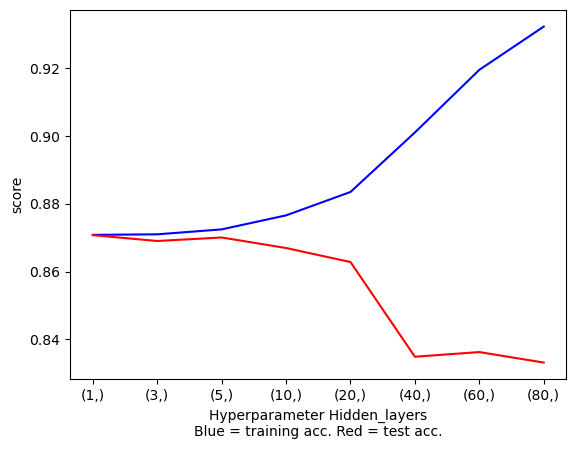

In [16]:
import matplotlib.pyplot as plt
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),
test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),hl_test_set_cv1)
plt.ylabel('score')
plt.show()

Total number of models:  8


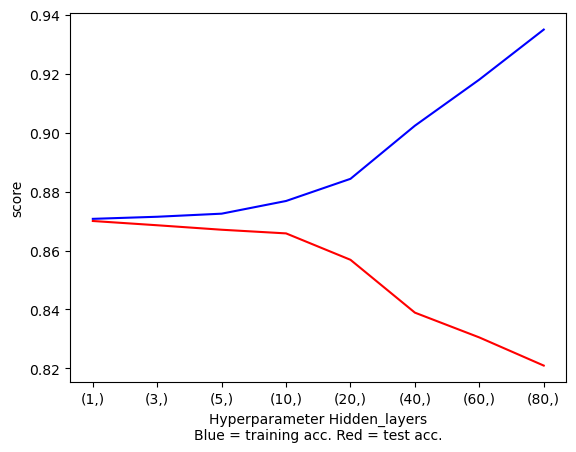

In [17]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)),
test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),hl_test_set_cv1)
plt.ylabel('score')
plt.show()

In [18]:
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))
y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_1.best_params_)

Train accuracy: 0.8706429925874849
Test accuracy: 0.8703241895261845
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.47      0.01      0.02      1610

    accuracy                           0.87     12431
   macro avg       0.67      0.50      0.47     12431
weighted avg       0.82      0.87      0.81     12431

{'hidden_layer_sizes': (1,)}


In [19]:
# CV2 tune hidde layer = 1
# new parameters
params = {'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,)]}
cv_2 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_2.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,)]})

In [23]:
print("Train accuracy:", cv_2.score(X_train, y_train))
print("Test accuracy:", cv_2.score(X_test, y_test))
y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_2.best_params_)

Train accuracy: 0.8705050853301155
Test accuracy: 0.8704850776285094
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.00      0.00      0.00      1610

    accuracy                           0.87     12431
   macro avg       0.44      0.50      0.47     12431
weighted avg       0.76      0.87      0.81     12431

{'hidden_layer_sizes': (4,)}


In [26]:
# CV3 tune alpha
params = {'hidden_layer_sizes': [(3,), (4,), (5,), (7,), (9,)], 'alpha': [0.01, 0.001, 0.0001,
0.00001]}
cv_3 = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_3.fit(X_train, y_train)
print("Train accuracy:", cv_3.score(X_train, y_train))
print("Test accuracy:", cv_3.score(X_test, y_test))
y_pred = cv_3.predict(X_test)
print(classification_report(y_test, y_pred))
print(cv_3.best_params_)

Train accuracy: 0.8705050853301155
Test accuracy: 0.8704850776285094
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.00      0.00      0.00      1610

    accuracy                           0.87     12431
   macro avg       0.44      0.50      0.47     12431
weighted avg       0.76      0.87      0.81     12431

{'alpha': 0.01, 'hidden_layer_sizes': (4,)}


In [27]:
# Recursive Feature Elimination using Logistic Regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
rfe = RFECV(estimator = LogisticRegression(random_state=random_state), cv=10)
rfe.fit(X_train, y_train)
print(rfe.n_features_)

13


In [28]:
# RFE_CV Result
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001,
0.00001]}
rfe_cv = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train)
print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test))
y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))
print(rfe_cv.best_params_)

Train accuracy: 0.8705050853301155
Test accuracy: 0.870404633577347
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.43      0.00      0.00      1610

    accuracy                           0.87     12431
   macro avg       0.65      0.50      0.47     12431
weighted avg       0.81      0.87      0.81     12431

{'alpha': 0.0001, 'hidden_layer_sizes': (3,)}


In [31]:
# Feature Selecting using decision tree
import pickle
from sklearn.feature_selection import SelectFromModel
with open('pickle/020925_DT.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)
selectmodel = SelectFromModel(dt_best, prefit=True)

# Fit the SelectFromModel instance to your training data
# This step is crucial and was missing in your original code
selectmodel.fit(X_train, y_train)

X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)
print(X_train_sel_model.shape)

(29005, 12)


In [32]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}
cv_sel_model = GridSearchCV(param_grid=params,
estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)
print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))
y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv_sel_model.best_params_)


Train accuracy: 0.8706774694018272
Test accuracy: 0.870404633577347
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     10821
           1       0.45      0.00      0.01      1610

    accuracy                           0.87     12431
   macro avg       0.66      0.50      0.47     12431
weighted avg       0.82      0.87      0.81     12431

{'alpha': 1e-05, 'hidden_layer_sizes': (5,)}


In [33]:
# Comparing the models to find the best performing model
# A total of six models has been built:
# 1. Default neural network ( model )
# 2. Neural network + grid search ( cv_1 )
# 3. Neural network + grid search ( cv_2 )
# 4. Neural network + grid search ( cv_3 )
# 5. Neural network + feature selection + grid search ( rfe_cv )
# 6. Neural network + feature selection using DT + grid search ( cv_sel_model )

from sklearn.metrics import roc_auc_score
y_pred_proba_nn = model.predict_proba(X_test)
y_pred_proba_cv_1 = cv_1.predict_proba(X_test)
y_pred_proba_cv_2 = cv_2.predict_proba(X_test)
y_pred_proba_cv_3 = cv_3.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_rfe)
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_cv_1 = roc_auc_score(y_test, y_pred_proba_cv_1[:, 1])
roc_index_cv_2 = roc_auc_score(y_test, y_pred_proba_cv_2[:, 1])
roc_index_cv_3 = roc_auc_score(y_test, y_pred_proba_cv_3[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])
print("ROC index on test for NN_default:", roc_index_nn)
print("ROC index on test for NN with gridsearch 1:", roc_index_cv_1)
print("ROC index on test for NN with gridsearch 2:", roc_index_cv_2)
print("ROC index on test for NN with gridsearch 3:", roc_index_cv_3)
print("ROC index on test for NN with feature selection and gridsearch:",
roc_index_rfe_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)



ROC index on test for NN_default: 0.5963679433996812
ROC index on test for NN with gridsearch 1: 0.6960263600624734
ROC index on test for NN with gridsearch 2: 0.69614833361172
ROC index on test for NN with gridsearch 3: 0.698686875818299
ROC index on test for NN with feature selection and gridsearch: 0.6979167491781852
ROC index on test for NN with feature selection (model selection) and gridsearch: 0.706928441993111


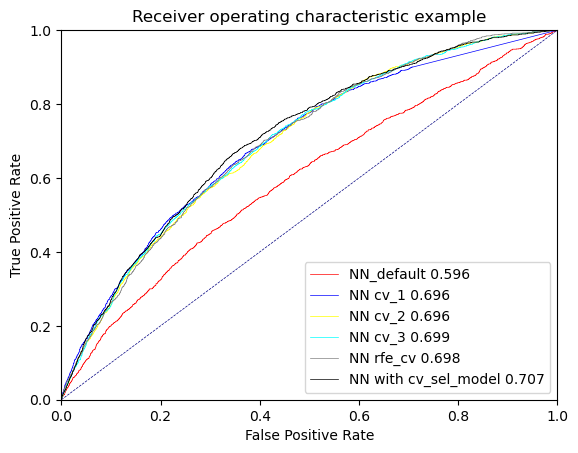

In [34]:
from sklearn.metrics import roc_curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_cv_1, tpr_cv_1, thresholds_cv_1 = roc_curve(y_test, y_pred_proba_cv_1[:,1])
fpr_cv_2, tpr_cv_2, thresholds_cv_2 = roc_curve(y_test, y_pred_proba_cv_2[:,1])
fpr_cv_3, tpr_cv_3, thresholds_cv_3 = roc_curve(y_test, y_pred_proba_cv_3[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test,
y_pred_proba_cv_sel_model[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr_nn, tpr_nn, label='NN_default {:.3f}'.format(roc_index_nn), color='red',
lw=0.5)
plt.plot(fpr_cv_1, tpr_cv_1, label='NN cv_1 {:.3f}'.format(roc_index_cv_1), color='blue',
lw=0.5)
plt.plot(fpr_cv_2, tpr_cv_2, label='NN cv_2 {:.3f}'.format(roc_index_cv_2),
color='yellow', lw=0.5)
plt.plot(fpr_cv_3, tpr_cv_3, label='NN cv_3 {:.3f}'.format(roc_index_cv_3), color='cyan',
lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='NN rfe_cv {:.3f}'.format(roc_index_rfe_cv),
color='gray', lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='black', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ROC index on test for decision tree: 0.6771720045161782
ROC index on test for linear regression: 0.6996361457276826
ROC index on test for NN with feature selection (model selection) and gridsearch: 0.706928441993111


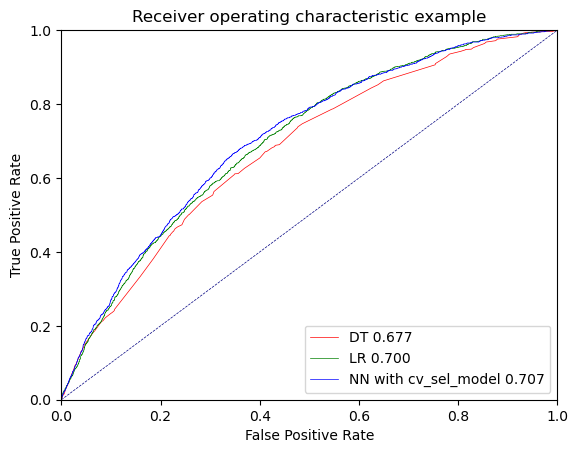

In [35]:
import pickle
with open('pickle/020925_DT.pickle', 'rb') as f:
    dt_best, roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)
with open('pickle/020925_LR.pickle', 'rb') as f:
    lr_best, roc_index_lr_cv, fpr_lr_cv, tpr_lr_cv = pickle.load(f)
print("ROC index on test for decision tree:", roc_index_dt_cv)
print("ROC index on test for linear regression:", roc_index_lr_cv)
print("ROC index on test for NN with feature selection (model selection) and gridsearch:", roc_index_cv_sel_model)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='DT {:.3f}'.format(roc_index_dt_cv), color='red',
lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='LR {:.3f}'.format(roc_index_lr_cv), color='green',
lw=0.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model {:.3f}'.format(roc_index_cv_sel_model), color='blue', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [36]:
def debug_dataframe(df):
    print("=== DataFrame Debugging ===")
    print(f"Shape: {df.shape}")
    print("\n=== Data Types ===")
    print(df.dtypes)

    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\n=== Infinite Values ===")
    for col in df.select_dtypes(include=[np.number]).columns:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            print(f"{col}: {inf_count} infinite values")

    print("\n=== Non-Numeric in Numeric Columns ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        non_numeric = df[col].apply(lambda x: isinstance(x, str)).sum()
        if non_numeric > 0:
            print(f"{col}: {non_numeric} non-numeric values")

    print("\n=== Categorical Columns ===")
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(categorical_cols)

    print("\n=== Sample Data ===")
    print(df.head())

# Run the debugging function
debug_dataframe(X)

=== DataFrame Debugging ===
Shape: (41436, 124)

=== Data Types ===
VehOdo                           float64
MMRAcquisitonRetailCleanPrice    float64
MMRCurrentRetailCleanPrice       float64
MMRCurrentRetailRatio            float64
VehBCost                         float64
                                  ...   
VNST_TX                             bool
VNST_UT                             bool
VNST_VA                             bool
VNST_WA                             bool
VNST_WV                             bool
Length: 124, dtype: object

=== Missing Values ===
Series([], dtype: int64)

=== Infinite Values ===

=== Non-Numeric in Numeric Columns ===

=== Categorical Columns ===
Index([], dtype='object')

=== Sample Data ===
    VehOdo  MMRAcquisitonRetailCleanPrice  MMRCurrentRetailCleanPrice  \
0  51099.0                        10571.0                     12505.0   
1  48542.0                        10571.0                     10571.0   
2  46318.0                        10682.0    